## Check for Programmatic variations


check which hybrid performed best do we prefer precision or recall

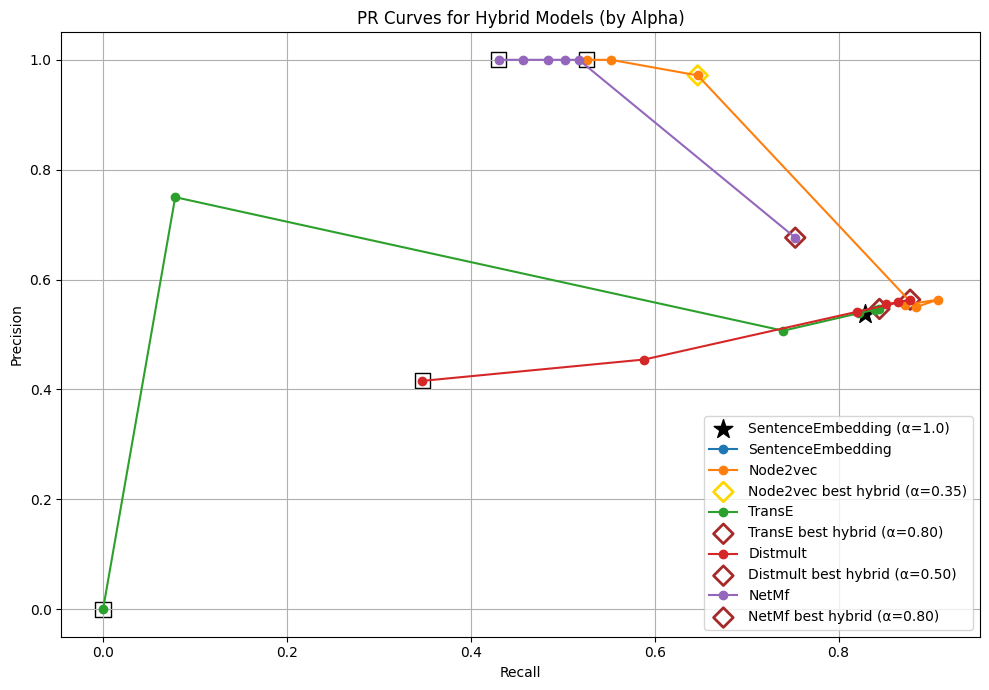

In [44]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
noise = 'high'
# Path and file setup
match_dir = f"matches_{noise}"

golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')
model_bases = {
    'SentenceEmbedding': "SentenceEmbedding",
    'Node2vec': "HybridNode2vecLow_alpha_",
    'TransE': "HybridTransE_alpha_",
    'Distmult': "HybridDistmult_alpha_",
    'NetMf': "HybridNetMf_alpha_",
}
alpha_values = [0.0, 0.2, 0.35, 0.5, 0.65, 0.8, 1.0]

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

def evaluate_matches(match_data, golden_standard):
    identifiers = []
    true_duplicate_pairs = set()
    for match in match_data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        # Always add all pairs to identifiers
        identifiers.append(pair)
        # If this match is an exact/true duplicate, remember the pair
        if match.get('duplication_type') == 'true_duplicate':
            # Use sorted tuple to be order-agnostic
            uuid1, uuid2 = pair['entity1'], pair['entity2']
            true_duplicate_pairs.add(tuple(sorted([uuid1, uuid2])))
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    # Filter out 'true_duplicate' pairs from the false positives
    false_positives = (matched_pairs_set - golden_pairs_set) - true_duplicate_pairs

    TP = len([
        1 for pair in matched_pairs_set if pair in golden_pairs_set
    ])
    FP = len(false_positives)
    FN = len(golden_pairs_set - matched_pairs_set)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

# Prepare to store results
pr_curves = {model: {'precisions': [], 'recalls': [], 'alphas': []} for model in model_bases.keys()}

for model, base in model_bases.items():
    for alpha in alpha_values:
        if alpha == 1.0:
            filename = os.path.join(match_dir, "SentenceEmbedding.json")
        else:
            filename = os.path.join(match_dir, f"{base}{alpha}.json")
        if not os.path.exists(filename):
            continue
        with open(filename, 'r') as f:
            match_data = json.load(f)
        precision, recall = evaluate_matches(match_data, golden_standard)
        pr_curves[model]['precisions'].append(precision)
        pr_curves[model]['recalls'].append(recall)
        pr_curves[model]['alphas'].append(alpha)

# Find the best model and alpha (highest F1 among all models and alphas except alpha=1.0)
best_model = None
best_alpha = None
best_f1 = -1
best_idx = None

for model, curve in pr_curves.items():
    for i, (p, r, a) in enumerate(zip(curve['precisions'], curve['recalls'], curve['alphas'])):
        if a == 1.0:
            continue  # skip SentenceEmbedding
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_alpha = a
            best_idx = i

plt.figure(figsize=(10, 7))

# Plot SentenceEmbedding (alpha=1.0) only once
if 'SentenceEmbedding.json' in [os.path.basename(os.path.join(match_dir, "SentenceEmbedding.json"))]:
    se_precision, se_recall = None, None
    for model, curve in pr_curves.items():
        for i, alpha in enumerate(curve['alphas']):
            if alpha == 1.0:
                se_precision = curve['precisions'][i]
                se_recall = curve['recalls'][i]
                break
    if se_precision is not None and se_recall is not None:
        plt.scatter(se_recall, se_precision, marker='*', s=200, color='black', label='SentenceEmbedding (α=1.0)')

# Plot each model's PR curve, highlight best hybrid, and highlight alpha=0.0
for model, curve in pr_curves.items():
    hybrid_recalls = [r for a, r in zip(curve['alphas'], curve['recalls']) if a != 1.0]
    hybrid_precisions = [p for a, p in zip(curve['alphas'], curve['precisions']) if a != 1.0]
    hybrid_alphas = [a for a in curve['alphas'] if a != 1.0]
    plt.plot(hybrid_recalls, hybrid_precisions, marker='o', label=model)
    # Highlight starting point (alpha=0.0)
    if 0.0 in curve['alphas']:
        idx0 = curve['alphas'].index(0.0)
        plt.scatter(curve['recalls'][idx0], curve['precisions'][idx0], marker='s', s=120, color='none', edgecolor='black')
    # Find best hybrid (highest F1)
    best_idx_model = None
    best_f1_model = -1
    for i, (p, r) in enumerate(zip(hybrid_precisions, hybrid_recalls)):
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1_model:
            best_f1_model = f1
            best_idx_model = i
    if best_idx_model is not None:
        marker_color = 'gold' if model == best_model else 'brown'
        plt.scatter(hybrid_recalls[best_idx_model], hybrid_precisions[best_idx_model], marker='D', s=100, edgecolor=marker_color, facecolor='none', linewidths=2, label=f"{model} best hybrid (α={hybrid_alphas[best_idx_model]:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves for Hybrid Models (by Alpha)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Use the Best hybrid and compare the methods to one another


=== Sent_upgraded ===
Predicted pairs: 1200
True Duplicates Predicted: 147
True Positives: 570
False Positives: 489
False Negatives: 118
Precision: 0.5382
Recall: 0.8285
F1 Score: 0.6525

=== TransE.8 ===
Predicted pairs: 1207
True Duplicates Predicted: 150
True Positives: 581
False Positives: 482
False Negatives: 107
Precision: 0.5466
Recall: 0.8445
F1 Score: 0.6636

=== Distmult.5 ===
Predicted pairs: 1222
True Duplicates Predicted: 155
True Positives: 604
False Positives: 468
False Negatives: 84
Precision: 0.5634
Recall: 0.8779
F1 Score: 0.6864

=== NetMf.8 ===
Predicted pairs: 842
True Duplicates Predicted: 78
True Positives: 518
False Positives: 248
False Negatives: 170
Precision: 0.6762
Recall: 0.7529
F1 Score: 0.7125

=== Node2vec.8 ===
Predicted pairs: 1225
True Duplicates Predicted: 148
True Positives: 600
False Positives: 483
False Negatives: 88
Precision: 0.5540
Recall: 0.8721
F1 Score: 0.6776


Precision, Recall, F1 Score per Method:
               Precision  Recall  F1 Sco

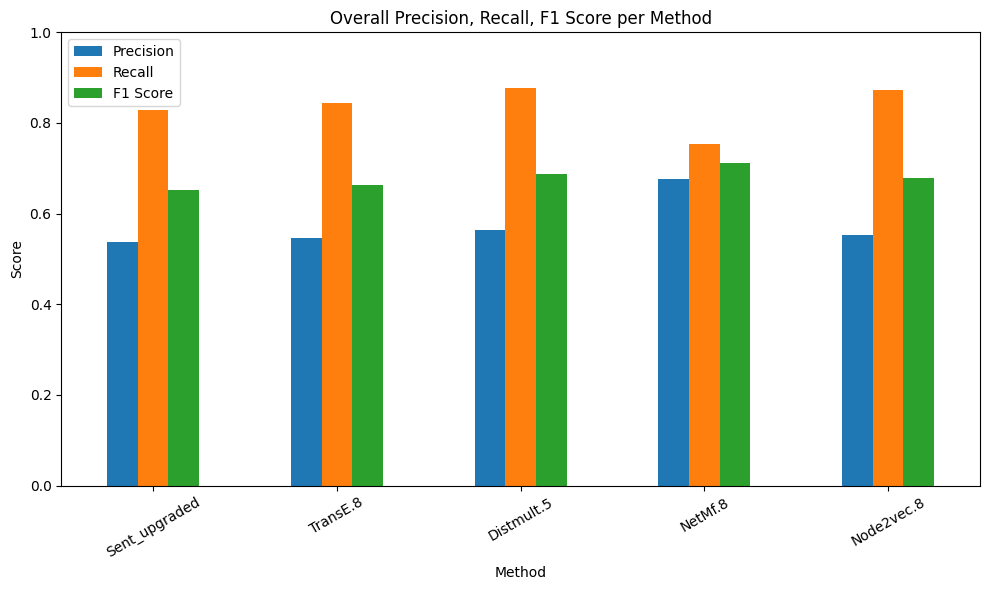

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt

noise = 'high'
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

# Define which match files to analyze
match_files = {
    'Sent_upgraded': f'matches_{noise}/SentenceEmbedding.json',
    'TransE.8' : f'matches_{noise}/HybridTransE_alpha_0.8.json',
    'Distmult.5': f'matches_{noise}/HybridDistmult_alpha_0.5.json',
    'NetMf.8' : f'matches_{noise}/HybridNetMf_alpha_0.8.json',
    'Node2vec.8': f'matches_{noise}/HybridNode2vecLow_alpha_0.8.json',
}

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

precision_recall_summary = {}
percent_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Collect all predicted pairs & label exact matches in one pass ---
    pair_tuples = []
    true_dup_pairs = set()
    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        pair_tuples.append(pair)
        if match.get("duplication_type") == "true_duplicate":
            true_dup_pairs.add(pair)

    matched_pairs_set = set(pair_tuples)
    golden_pairs_set = set(
        tuple(sorted([row['original_id'], row['duplicate_id']]))
        for _, row in golden_standard.iterrows()
    )

    # -- Metrics: TP, FP (excluding true_duplicate not in golden), FN --
    TP = len(matched_pairs_set & golden_pairs_set)
    # Exclude predicted "exact/true_duplicate" pairs that are not in the golden set from FP
    FP = len((matched_pairs_set - golden_pairs_set) - true_dup_pairs)
    FN = len(golden_pairs_set - matched_pairs_set)

    predicted_not_in_golden = matched_pairs_set - golden_pairs_set
    true_duplicates_predicted = true_dup_pairs
    # Save in a summary dict for later
    if 'analysis' not in locals():
        analysis = {}
    analysis[match_type] = {
        'predicted_not_in_golden': list(predicted_not_in_golden),
        'true_duplicates_predicted': list(true_duplicates_predicted)}

    # # Optionally, also save to file for inspection
    # with open(f"{match_type}_predicted_not_in_golden.json", "w") as f:
    #     json.dump(list(predicted_not_in_golden), f)
    # with open(f"{match_type}_true_duplicates_predicted.json", "w") as f:
    #     json.dump(list(true_duplicates_predicted), f)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"=== {match_type} ===")
    print(f"Predicted pairs: {len(pair_tuples)}")
    print(f"True Duplicates Predicted: {sum(1 for match in data if match.get('duplication_type') == 'true_duplicate')}")
    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {F1_score:.4f}\n")

    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall, 'F1 Score': F1_score}

    # --- Analysis by variation/entity type: use golden_standard, mark which pairs matched ---
    golden_standard['pair_key'] = golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])), axis=1)
    golden_standard['matched'] = golden_standard['pair_key'].isin(matched_pairs_set)

    # Variation-type analysis
    variation_stats = golden_standard.groupby('variation_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    variation_stats['Matched (%)'] = variation_stats['Matched_Count'] / variation_stats['Golden_Standard_Count'] * 100

    # Entity-type analysis
    entity_stats = golden_standard.groupby('entity_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    entity_stats['Matched (%)'] = entity_stats['Matched_Count'] / entity_stats['Golden_Standard_Count'] * 100

    # Combined variation/entity-type analysis
    combo_stats = golden_standard.groupby(['variation_type', 'entity_type']).agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    combo_stats['Matched (%)'] = combo_stats['Matched_Count'] / combo_stats['Golden_Standard_Count'] * 100
    combo_stats = combo_stats.reset_index().sort_values(['variation_type', 'entity_type'])

    # Save for plotting
    percent_summary[match_type] = entity_stats['Matched (%)']

    # (Optional: print for debugging)
    # print(variation_stats)
    # print(entity_stats)
    # print(combo_stats)

# --- Final Reporting and Plotting ---
pr_df = pd.DataFrame(precision_recall_summary).T.round(4)
print("\nPrecision, Recall, F1 Score per Method:")
print(pr_df)

# Barplot: Percentage of matched duplicates by entity type
pr_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Overall Precision, Recall, F1 Score per Method')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Number of missing golden_standard pairs: 118


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
65,ea5fe267-5877-4d3a-a8b5-a07a9659a673,49e76b10-eba7-4884-97df-e6d6bceb6d96,Address,country_expansion,country,AT,Austria
105,92d6ff73-5b3a-4595-8458-92c14e0e15d3,4d8244da-3e6f-4a18-9d76-d9ba4272fcff,HealthcareOrganization,name_abbreviation,healthcareOrganizationName,"Delgado, Guerrero and Simpson Zorg",DGS Zorg
116,bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78,fd85d57d-1847-4560-90b7-8c153c43f9dd,ServiceDepartment,department_typo,serviceDepartmentName,Geriatric,Geiatric
119,de9ac8b8-640b-4b28-8322-b4ff856df911,fc62388a-1bad-4a19-92c1-8e81c7351050,ServiceDepartment,translation,serviceDepartmentName,Renal,Nieren
126,6689ef79-f8c3-4461-bc15-b016487eb3df,a56e3fcc-d5c5-4f3a-8e10-a9dea407e939,ServiceDepartment,department_typo,serviceDepartmentName,Pediatric,Pldiatric
...,...,...,...,...,...,...,...
911,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine
915,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord
923,fae3fcee-7636-4fd9-8376-ffa876fe579f,644064d5-1f21-49b4-8748-66303f5b02e8,ContactPoint,email_typo,email,PerezBecker@healthcare.org,PerzeBecker@healthcare.org
925,6efeb18f-aaa6-4ef9-bbb6-ba4c140ab78e,0a671326-68dd-4e6f-ac93-fd83642e2475,ContactPoint,translation,contactType,staff,personeel



Precision/Recall/F1 per entity type for Sent_upgraded:
                        Precision  Recall      F1
Address                    1.0000  0.9902  0.9951
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2731  0.6889  0.3912
Person                     1.0000  0.8228  0.9028
HealthcarePersonnel        1.0000  0.8481  0.9178
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for TransE.8:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2888  0.7444  0.4161
Person                     1.0000  0.8323  0.9085
HealthcarePersonnel        1.0000  0.8639  0.9270
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for Distmult.5:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.5000  1.000

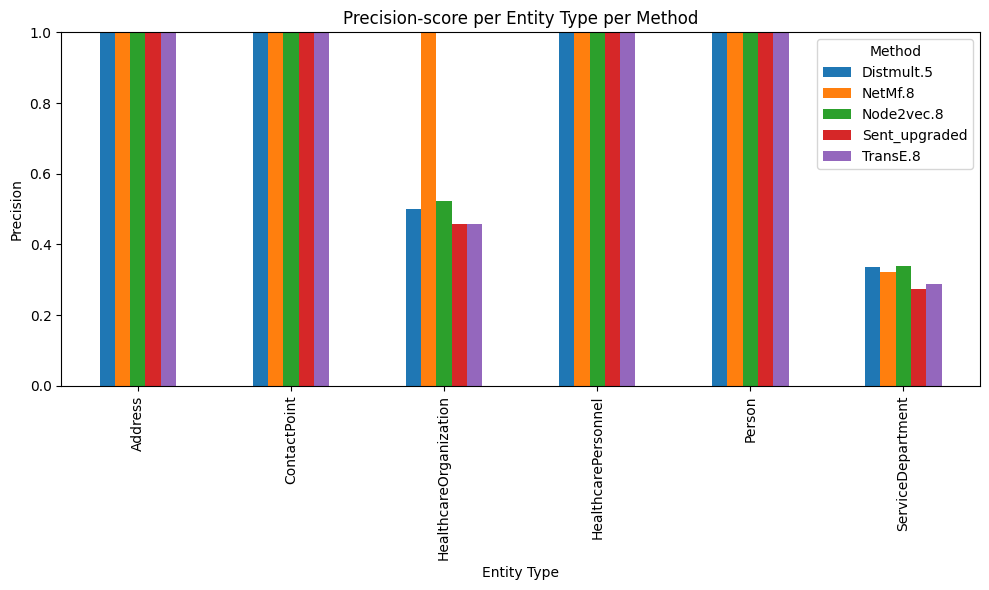

In [43]:

# -- Setup (same as before) --
noise = 'high'
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')
match_files = {
    'Sent_upgraded': f'matches_{noise}/SentenceEmbedding.json',
    'TransE.8' : f'matches_{noise}/HybridTransE_alpha_0.8.json',
    'Distmult.5': f'matches_{noise}/HybridDistmult_alpha_0.5.json',
    'NetMf.8' : f'matches_{noise}/HybridNetMf_alpha_0.8.json',
    'Node2vec.8': f'matches_{noise}/HybridNode2vecLow_alpha_0.8.json',
}

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

entity_type_pr_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Extract all predicted pairs and true_duplicate pairs once ---
    all_pairs = []
    all_pair_to_type = {}
    true_dup_pairs = set()

    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        all_pairs.append(pair)
        # Try to infer entity_type (from entity1 or entity2) if possible, or skip
        # (Here, you should store all types involved for later filtering)
        all_pair_to_type[pair] = None  # will filter per entity_type later
        if match.get("duplication_type") in ['true_duplicate', 'exact']:
            true_dup_pairs.add(pair)

    all_pairs_set = set(all_pairs)

    # -- Per-entity-type PRF calculation --
    prf_per_entity = {}
    entity_types = golden_standard['entity_type'].unique()

    for entity_type in entity_types:
        # Filter golden standard for this entity type
        gold_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        gold_type_pairs = set(tuple(sorted([row['original_id'], row['duplicate_id']]))
                              for _, row in gold_type_df.iterrows())
        valid_ids = set(gold_type_df['original_id']).union(set(gold_type_df['duplicate_id']))

        # Predicted pairs where both entities are of the current type
        pred_type_pairs = set(pair for pair in all_pairs_set if pair[0] in valid_ids and pair[1] in valid_ids)

        # Exclude "exact"/"true_duplicate" predictions not in golden for this entity type
        exact_not_in_golden = len([pair for pair in pred_type_pairs - gold_type_pairs if pair in true_dup_pairs])

        TP = len(pred_type_pairs & gold_type_pairs)
        FP = len(pred_type_pairs - gold_type_pairs) #- exact_not_in_golden
        FN = len(gold_type_pairs - pred_type_pairs)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}

    entity_type_pr_summary[match_type] = prf_per_entity

# -- To DataFrames and Display --
entity_prf_dfs = {method: pd.DataFrame(prf).T.round(4) for method, prf in entity_type_pr_summary.items()}

for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]
# print("\nCombined Precision/Recall/F1 per entity type:")
# print(combined_df)

# Plot Recall (change 'Recall' to 'F1' for F1 plot)
pivot_table = combined_df.pivot(index='Entity Type', columns='Method', values='Precision')
pivot_table.plot(kind='bar', figsize=(10,6))
plt.title('Precision-score per Entity Type per Method')
plt.ylabel('Precision')
plt.ylim(0,1)
plt.tight_layout()
plt.show()



Precision/Recall/F1 per entity type for Sent_upgraded:
                        Precision  Recall      F1
Address                    1.0000  0.9902  0.9951
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2731  0.6889  0.3912
Person                     1.0000  0.8228  0.9028
HealthcarePersonnel        1.0000  0.8481  0.9178
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for TransE.8:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2888  0.7444  0.4161
Person                     1.0000  0.8323  0.9085
HealthcarePersonnel        1.0000  0.8639  0.9270
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for Distmult.5:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.5000  1.000

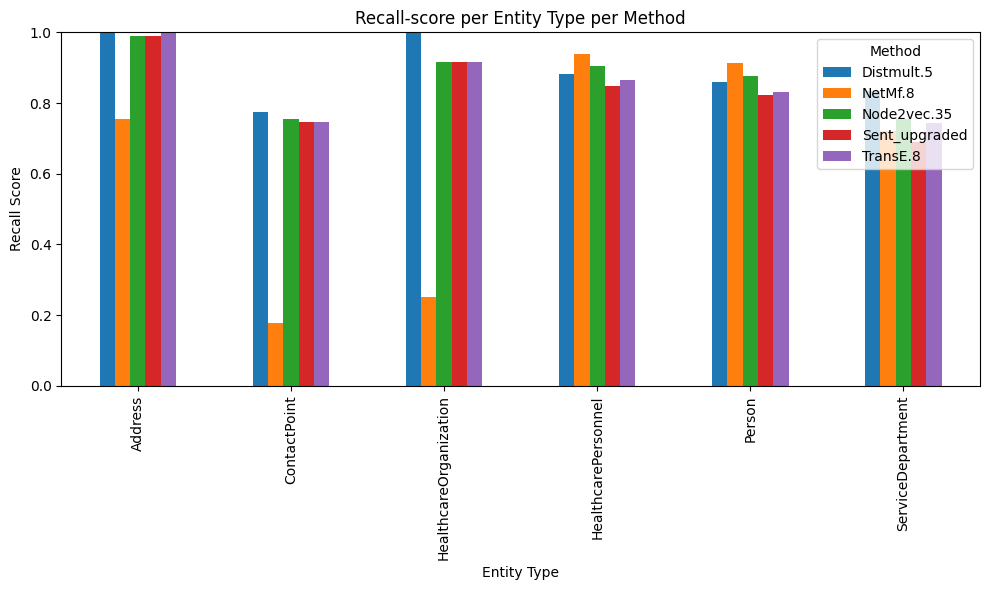

In [28]:
import pandas as pd
import json
import matplotlib.pyplot as plt

def extract_uuid(uri):
    return uri.split("/")[-1]

precision_recall_summary = {}
percent_summary = {}
entity_type_pr_summary = {}

for match_type, data in match_files.items():
    identifiers = []
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # === PER-ENTITY TYPE PRF computation ===
    prf_per_entity = {}

    # List of entity types in the golden standard
    entity_types = golden_standard['entity_type'].unique()
    # ...existing code...
    for entity_type in entity_types:
        # Filter golden pairs for this entity type
        golden_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        golden_pairs_set = set(
            (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
            for _, row in golden_type_df.iterrows()
        )
        valid_ids = set(golden_type_df['original_id']).union(set(golden_type_df['duplicate_id']))
        found_pairs_set = set(
            (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
            for pair in identifiers
            if pair['entity1'] in valid_ids and pair['entity2'] in valid_ids
        )

        # Find "exact" matches not in golden for this entity type
        exact_not_in_golden = 0
        for match in data:
            # Only consider matches for this entity type
            # (Assumes you have entity_type info in your match or can infer it)
            entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
            entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
            uuid1 = extract_uuid(entity1.get("subject"))
            uuid2 = extract_uuid(entity2.get("subject"))
            pair = (uuid1, uuid2) if uuid1 <= uuid2 else (uuid2, uuid1)
            if uuid1 in valid_ids and uuid2 in valid_ids:
                if pair not in golden_pairs_set and match.get("duplication_type") == "true_duplicate":
                    exact_not_in_golden += 1

        TP = len(golden_pairs_set & found_pairs_set)
        FP = len(found_pairs_set - golden_pairs_set) - exact_not_in_golden
        FN = len(golden_pairs_set - found_pairs_set)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}
        entity_type_pr_summary[match_type] = prf_per_entity

# Convert results to DataFrames for nice display
entity_prf_dfs = {}
for method, prf_dict in entity_type_pr_summary.items():
    df = pd.DataFrame(prf_dict).T  # entity_type as index
    entity_prf_dfs[method] = df.round(4)

# Display all PRF tables for each method
for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

# If you want a combined table:
combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]


# You can also plot per-entity F1 for all methods
f1_table = combined_df.pivot(index='Entity Type', columns='Method', values='Recall')
f1_table.plot(kind='bar', figsize=(10,6))
plt.title('Recall-score per Entity Type per Method')
plt.ylabel('Recall Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [49]:
import pandas as pd
import json

# --- 1. Load golden standard and build id -> entity_type mapping ---
golden_standard = pd.read_csv('data/test_golden_standard_high.csv')
id_to_type = {}
for _, row in golden_standard.iterrows():
    id_to_type[row['original_id']] = row['entity_type']
    id_to_type[row['duplicate_id']] = row['entity_type']
all_golden_ids = set(id_to_type.keys())

# --- 2. Load predicted pairs (not in golden) ---
with open('error_analysis/Node2vec.8_predicted_not_in_golden.json', 'r') as f:
    pairs = json.load(f)

# --- 3. Check first identifier of each pair and collect entity type if matched ---
match_info = []
for pair in pairs:
    first_id = pair[0]
    if first_id in id_to_type:
        match_info.append({'id': first_id, 'entity_type': id_to_type[first_id], 'pair': pair})

# --- 4. Make a DataFrame and print entity type counts ---
df = pd.DataFrame(match_info)
print("Matched first identifiers by entity type:\n")
if not df.empty:
    print(df['entity_type'].value_counts())
    print("\nSample matches:\n", df.head())
else:
    print("No matches found for the given pairs.")


Matched first identifiers by entity type:

entity_type
ServiceDepartment         259
HealthcareOrganization     31
Name: count, dtype: int64

Sample matches:
                                      id             entity_type  \
0  09463e6f-3215-400e-a272-e2af92126ff1       ServiceDepartment   
1  76be8a0e-ed64-4bd1-a1b6-29a8fadd6ac1       ServiceDepartment   
2  7766f556-ce51-4ffc-943d-da2a7bacbd85       ServiceDepartment   
3  02246f10-ce65-4211-a3c9-c8d76ceb1865       ServiceDepartment   
4  5b87eb29-8f62-440c-a417-f1a31ec32201  HealthcareOrganization   

                                                pair  
0  [09463e6f-3215-400e-a272-e2af92126ff1, 46a6c03...  
1  [76be8a0e-ed64-4bd1-a1b6-29a8fadd6ac1, 798246e...  
2  [7766f556-ce51-4ffc-943d-da2a7bacbd85, e52bd55...  
3  [02246f10-ce65-4211-a3c9-c8d76ceb1865, 9711c99...  
4  [5b87eb29-8f62-440c-a417-f1a31ec32201, da98da5...  


In [46]:
# Find golden_standard pairs that were NOT matched by the current method (NetMf.8)
# Use the pair_tuples (predicted pairs) and golden_standard DataFrame

# Create set of predicted pairs for fast lookup
predicted_pairs_set = set(pair_tuples)

# Create set of golden standard pairs (order-agnostic)
golden_pairs_set = set(
    tuple(sorted([row['original_id'], row['duplicate_id']]))
    for _, row in golden_standard.iterrows()
)

# Find missing pairs: those in golden_standard but not in predictions
missing_pairs = golden_pairs_set - predicted_pairs_set

# Optionally, get the rows from golden_standard corresponding to missing pairs
missing_rows = golden_standard[
    golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])) in missing_pairs,
        axis=1
    )
]

print(f"Number of missing golden_standard pairs: {len(missing_rows)}")
missing_rows

Number of missing golden_standard pairs: 118


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value,pair_key,matched
65,ea5fe267-5877-4d3a-a8b5-a07a9659a673,49e76b10-eba7-4884-97df-e6d6bceb6d96,Address,country_expansion,country,AT,Austria,"(49e76b10-eba7-4884-97df-e6d6bceb6d96, ea5fe26...",False
105,92d6ff73-5b3a-4595-8458-92c14e0e15d3,4d8244da-3e6f-4a18-9d76-d9ba4272fcff,HealthcareOrganization,name_abbreviation,healthcareOrganizationName,"Delgado, Guerrero and Simpson Zorg",DGS Zorg,"(4d8244da-3e6f-4a18-9d76-d9ba4272fcff, 92d6ff7...",False
116,bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78,fd85d57d-1847-4560-90b7-8c153c43f9dd,ServiceDepartment,department_typo,serviceDepartmentName,Geriatric,Geiatric,"(bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78, fd85d57...",False
119,de9ac8b8-640b-4b28-8322-b4ff856df911,fc62388a-1bad-4a19-92c1-8e81c7351050,ServiceDepartment,translation,serviceDepartmentName,Renal,Nieren,"(de9ac8b8-640b-4b28-8322-b4ff856df911, fc62388...",False
126,6689ef79-f8c3-4461-bc15-b016487eb3df,a56e3fcc-d5c5-4f3a-8e10-a9dea407e939,ServiceDepartment,department_typo,serviceDepartmentName,Pediatric,Pldiatric,"(6689ef79-f8c3-4461-bc15-b016487eb3df, a56e3fc...",False
...,...,...,...,...,...,...,...,...,...
911,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine,"(b0ca76f7-17f9-4524-8332-ed33bba6e752, bc0e731...",False
915,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord,"(1d3976f9-6b44-49dc-ae74-13f04b65e378, 84ddf86...",False
923,fae3fcee-7636-4fd9-8376-ffa876fe579f,644064d5-1f21-49b4-8748-66303f5b02e8,ContactPoint,email_typo,email,PerezBecker@healthcare.org,PerzeBecker@healthcare.org,"(644064d5-1f21-49b4-8748-66303f5b02e8, fae3fce...",False
925,6efeb18f-aaa6-4ef9-bbb6-ba4c140ab78e,0a671326-68dd-4e6f-ac93-fd83642e2475,ContactPoint,translation,contactType,staff,personeel,"(0a671326-68dd-4e6f-ac93-fd83642e2475, 6efeb18...",False


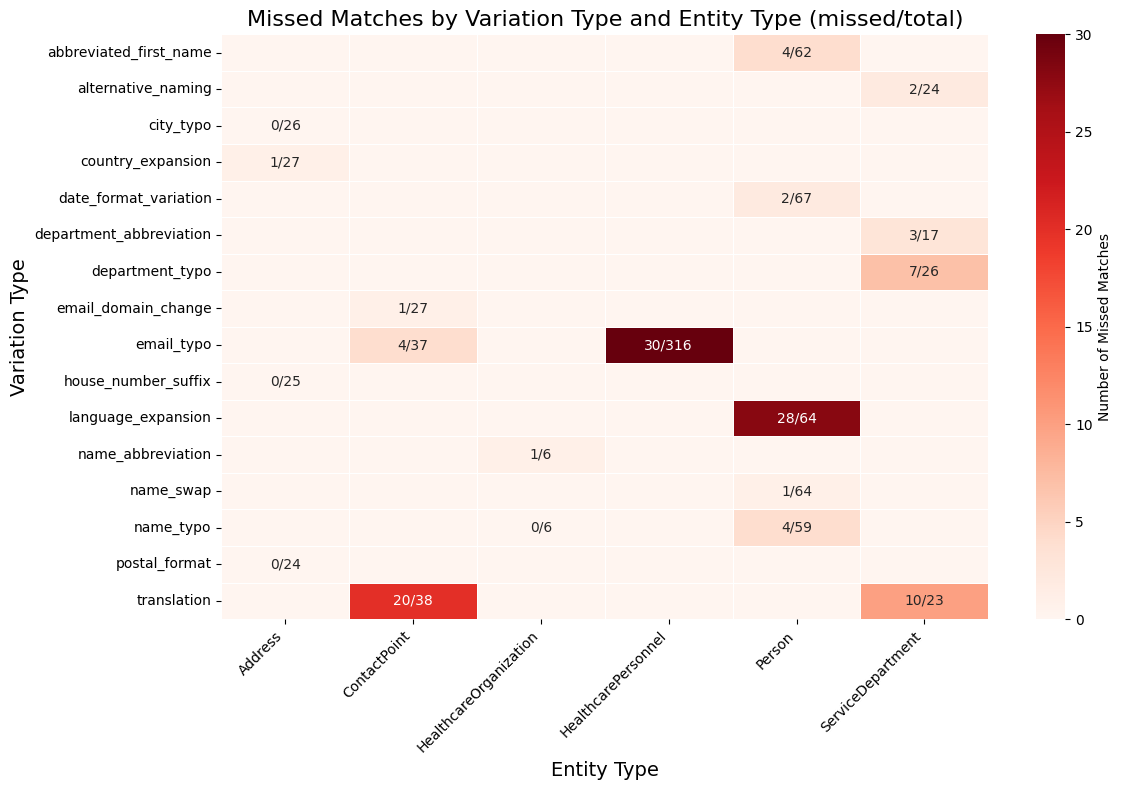

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missing_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)


# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Missed Matches by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Flat models Is this still Necessary


Matching Statistics for Sent_upgraded:
Number of matches in Sent_upgraded: 1200
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 778
Percentage Matched (%): 82.94

Matching Statistics for TransE:
Number of matches in TransE: 0
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 0
Percentage Matched (%): 0.00

Matching Statistics for Distmult:
Number of matches in Distmult: 602
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 335
Percentage Matched (%): 35.71

Matching Statistics for Node2vec:
Number of matches in Node2vec: 378
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 579
Percentage Matched (%): 61.73

Matching Statistics for NetMf:
Number of matches in NetMf: 306
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 491
Percentage Matched (%): 52.35



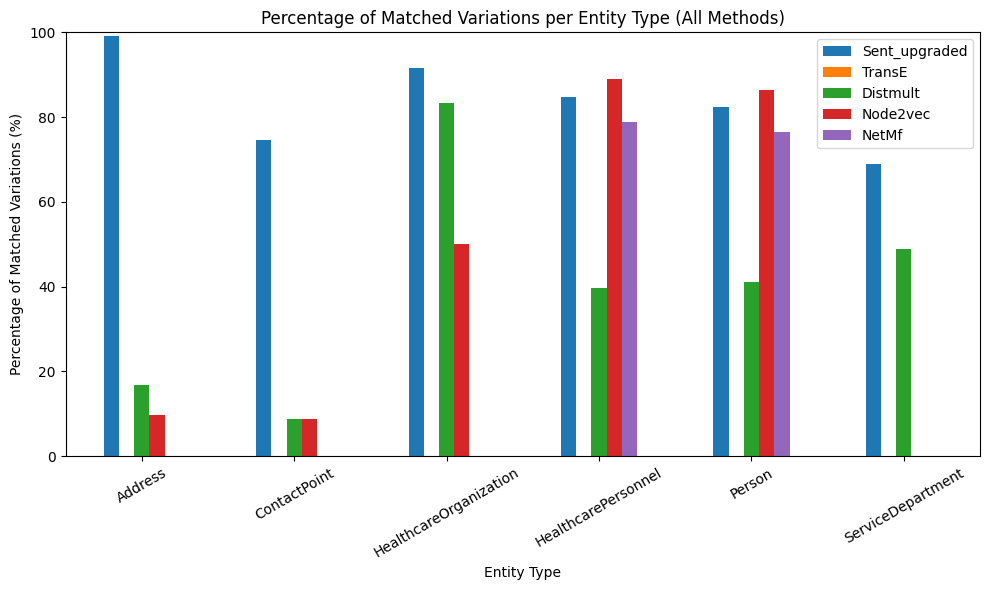

In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/test_golden_standard_high.csv')

# Load both match files
match_files = {
    'Sent_upgraded': json.load(open('matches_high/SentenceEmbedding.json', 'r')),
    'TransE' : json.load(open('matches_high/HybridTransE_alpha_0.0.json', 'r')),
    'Distmult': json.load(open('matches_high/HybridDistmult_alpha_0.0.json', 'r')),
    'Node2vec': json.load(open('matches_high/HybridNode2VecLow_alpha_0.0.json', 'r')),
    'NetMf' : json.load(open('matches_high/HybridNetMf_alpha_0.0.json', 'r')),

}

def extract_uuid(uri):
    return uri.split("/")[-1]
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched


percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (All Methods)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   

OLD P/R/F1 Calc

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
noise = 'high'
# # Load the CSV and JSON files
# golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

# #Load both match files
# match_files = {
    
#     'TransE.5' : json.load(open(f'matches_{noise}/HybridTransE_alpha_0.5.json', 'r')),
#     'Distmult.5': json.load(open(f'matches_{noise}/HybridDistmult_alpha_0.5.json', 'r')),
#     'NetMf.0.5' : json.load(open(f'matches_{noise}/HybridNetMf_alpha_0.5.json', 'r')),
#     'SentenceEmbedding': json.load(open(f'matches_{noise}/SentenceEmbedding_top_k5.json', 'r')),
#     'Node2vec.0.5': json.load(open(f'matches_{noise}/HybridNode2vecLow_alpha_0.5.json', 'r')),
    
# }

# Load the CSV and JSON files
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

# Load both match files
match_files = {
    'Sent_upgraded': json.load(open(f'matches_{noise}/SentenceEmbedding.json', 'r')),
    'TransE.8' : json.load(open(f'matches_{noise}/HybridTransE_alpha_0.8.json', 'r')),
    'Distmult.5': json.load(open(f'matches_{noise}/HybridDistmult_alpha_0.5.json', 'r')),
    'NetMf.8' : json.load(open(f'matches_{noise}/HybridNetMf_alpha_0.8.json', 'r')),
    'Node2vec.35': json.load(open(f'matches_{noise}/HybridNode2vecLow_alpha_0.8.json', 'r')),
}

def extract_uuid(uri):
    return uri.split("/")[-1]
precision_recall_summary = {} 
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100
    exact_count = sum(1 for item in data if item.get("duplication_type") == "true_duplicate")
    print(f"Number of exact matches: {exact_count}")
    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })
    # Calculate precision and recall
    # True Positives (TP): matched pairs that are in golden_standard
    TP = matched
    # False Positives (FP): matched pairs that are NOT in golden_standard
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )

        # Count "exact" matches not in golden standard
    exact_not_in_golden = 0
    for match in data:
        # Extract UUIDs
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1 = extract_uuid(entity1.get("subject"))
        uuid2 = extract_uuid(entity2.get("subject"))
        pair = (uuid1, uuid2) if uuid1 <= uuid2 else (uuid2, uuid1)
        # Check if not in golden and duplication_type is exact
        if pair not in golden_pairs_set and match.get("duplication_type") == "true_duplicate":
            exact_not_in_golden += 1

    print(f'Number of "exact" matches not in golden standard: {exact_not_in_golden}')
    FP = len(matched_pairs_set - golden_pairs_set) - exact_not_in_golden
    # False Negatives (FN): golden_standard pairs not matched
    FN = len(golden_pairs_set - matched_pairs_set)
    
    # precision, recall, and F1 score calculations
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall, 'F1 Score': F1_score}

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}\f")
    print(f"F1 Score: {F1_score:.4f}\n")

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched

pr_df = pd.DataFrame(precision_recall_summary).T  # Transpose for better display
pr_df = pr_df.round(4)
print("Precision and Recall per Method:")
display(pr_df)

percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (Best Hybrid Method)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   